## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


In [3]:
infile_r = None  # input file handle

#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc0.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc1.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc2.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc3.0.root'

#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc0.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc1.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc2.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc3.0.root'

#infile = '../test7/ntuple_SingleMuon_Endcap_200k.root'
infile = '../test7/ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root'
infile_PU200 = None

def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='simhits', prefix='vc_', size='vc_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def load_pgun_PU200():
  print('[INFO] Opening file: %s' % infile_PU200)
  global infile_r
  infile_r = root_open(infile_PU200)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

In [4]:
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

zpositions = [599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3, 0, 0, 0, 0]

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

In [5]:
def calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Propagate to station 2 (z = 850 cm), find r and eta of the track
  # (called rstar and etastar).
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  if eta < 0:
    zstar *= -1
  # Assume a simplified magnetic field where it is 4T (or 3.811T)
  # inside the solenoid and 0T outside (boundary at z = 650 cm)
  if eta < 0:
    zstar_4T *= -1
  B = 3.811
  R = -1.0 / (0.003 * B * invpt)  # R = -pT/(0.003 q B)  [cm], radius of the circle
  cot = np.sinh(eta)              # cot(theta), which is pz/pt
  if np.abs(zstar_4T) < np.abs(zstar):
    arg_term_4T = np.abs((zstar_4T - z0)/cot)                 # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = np.abs((zstar - zstar_4T)/cot)              # without magfield
    sin_term_0T = arg_term_0T                                 # without magfield
    cos_term_0T = 0                                           # without magfield
  else:
    # Also need to check for the boundary at r where 4T -> 0T, ignore for now
    arg_term_4T = np.abs((zstar - z0)/cot)                    # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = 0                                           # without magfield
    sin_term_0T = 0                                           # without magfield
    cos_term_0T = 0                                           # without magfield
  phistar_4T = phi + arg_term_4T/(2 * R)  # phi at the boundary where 4T -> 0T
  xstar = x0 + np.cos(phi) * sin_term_4T - np.sin(phi) * cos_term_4T + \
          np.cos(phistar_4T) * sin_term_0T - np.sin(phistar_4T) * cos_term_0T
  ystar = y0 + np.sin(phi) * sin_term_4T + np.cos(phi) * cos_term_4T + \
          np.sin(phistar_4T) * sin_term_0T + np.cos(phistar_4T) * cos_term_0T
  rstar = np.hypot(xstar, ystar)
  cotstar = zstar/rstar
  etastar = np.arcsinh(cotstar)
  return etastar

def calc_signed_rvtx(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Sign is positive if |etastar| <= |eta|, negative otherwise
  etastar = calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar, zstar_4T)
  rvtx = np.hypot(x0, y0)
  if not (np.abs(etastar) <= np.abs(eta)):
    rvtx *= -1
  return rvtx

## Main function

In [6]:
# Main function

def analysis(pileup=0):
  # Load tree
  if pileup == 200:
    tree = load_pgun_PU200()
  else:
    tree = load_pgun()
  
  # Event range
  #maxEvents = 100000
  maxEvents = 2000000
  
  # Output
  out_part_invpt, out_part_d0, out_part_eta, out_part_etastar = [], [], [], []
  out_hits_xmask, out_hits_etastar, out_hits_rvtx = [], [], []
  
  # ____________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events without particles
    if len(evt.particles) == 0:
      continue
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits - NOT APPLIED
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    # __________________________________________________________________________
    # Muon parameters
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    part.etastar = calc_etastar_from_eta(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz)
    part.rvtx = calc_signed_rvtx(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz)
    
    # Skip low pT muons - NOT APPLIED
    #if part.pt < 20:
    #  continue
    
    # Skip large r_vtx muons
    if np.hypot(part.vx, part.vy) > 150:
      continue
    
    # Use sim_tp == 1 only - NOT APPLIED
    f = lambda hit: (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)
    #selected_hits = filter(f, evt.hits)
    
    selected_hits = evt.hits
    
    # __________________________________________________________________________
    # Trigger primitive variables
    
    # Boolean mask array. For each station, check if there exists at least a trigger primitive.
    # 1: does not exist (default) 0: exists
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # eta & etastar
    x_etastar_array = np.zeros((nlayers,), dtype=np.float32)
    x_rvtx_array = np.zeros((nlayers,), dtype=np.float32)
    for lay in range(nlayers):
      x_etastar_array[lay] = calc_etastar_from_eta(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz, zpositions[lay])
      x_rvtx_array[lay] = calc_signed_rvtx(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz, zpositions[lay])
    
    # __________________________________________________________________________
    # Output
    
    out_part_invpt.append(part.invpt)
    out_part_d0.append(part.d0)
    out_part_eta.append(part.eta)
    out_part_etastar.append(part.etastar)
    out_hits_xmask.append(x_mask_array)
    out_hits_etastar.append(x_etastar_array)
    out_hits_rvtx.append(x_rvtx_array)
    
    continue  # end loop over events

  print("DONE")
  
  # Convert from lists into np arrays
  asarr = np.asarray
  res = (asarr(out_part_invpt), asarr(out_part_d0), asarr(out_part_eta), asarr(out_part_etastar),
         asarr(out_hits_xmask), asarr(out_hits_etastar), asarr(out_hits_rvtx),)
  return res

## Run analysis

In [7]:
%%time

res = analysis()

(out_part_invpt, out_part_d0, out_part_eta, out_part_etastar, 
 out_hits_xmask, out_hits_etastar, out_hits_rvtx) = res

[INFO] Opening file: ../test7/ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root
Processing event: 0
Processing event: 100000
Processing event: 200000
Processing event: 300000
Processing event: 400000
Processing event: 500000
Processing event: 600000
Processing event: 700000
Processing event: 800000
Processing event: 900000
Processing event: 1000000
Processing event: 1100000
Processing event: 1200000
Processing event: 1300000
Processing event: 1400000
Processing event: 1500000
Processing event: 1600000
Processing event: 1700000
Processing event: 1800000
Processing event: 1900000
DONE
CPU times: user 32min 50s, sys: 3min 46s, total: 36min 36s
Wall time: 33min 13s


In [8]:
# Verbose
print(out_part_invpt.shape, out_part_d0.shape, out_part_eta.shape, out_part_etastar.shape, out_part_invpt.dtype, out_part_d0.dtype, out_part_eta.dtype, out_part_etastar.dtype)
print(out_hits_xmask.shape, out_hits_etastar.shape, out_hits_rvtx.shape, out_hits_xmask.dtype, out_hits_etastar.dtype, out_hits_rvtx.dtype)

((583269,), (583269,), (583269,), (583269,), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))
((583269, 16), (583269, 16), (583269, 16), dtype('int32'), dtype('float32'), dtype('float32'))


## More setup

In [9]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [10]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [11]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, colorbar=False, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), **kwargs)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges, **kwargs)
  return h, edges, patches

In [12]:
class divide_context(object):
  """Context manager that avoids division by zero.
  
  Handle zeros in the denominator, replacing them by ones.
  Based on contextlib.nullcontext(enter_result=None)
  """

  def __init__(self, enter_result=None):
    self.enter_result = enter_result.copy()
    self.enter_result[self.enter_result == 0] = 1
  def __enter__(self):
    return self.enter_result
  def __exit__(self, *excinfo):
    pass

In [13]:
def decorate_hist(vlines=True, hlines=True):
  if vlines:
    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
      ax.plot([x,x], [ymin,ymax], '--', color='grey', lw=0.9)
  if hlines:
    for y in [0.95]:  # horizontal lines
      ax.plot([xmin,xmax], [y,y], '--', color='grey', lw=0.9)
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

def decorate_hist2d(vlines=True):
  if vlines:
    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
      ax.plot([x,x], [ymin,ymax], '--', color='grey', lw=0.9)
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

## Results (pT > 20 GeV)

In [14]:
# Prepare arrays

x_mask_array = out_hits_xmask.astype(np.bool, copy=True)
x_eta_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_eta[:,np.newaxis]
x_d0_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_d0[:,np.newaxis]
x_etastar_array = out_hits_etastar.copy()
x_rvtx_array = out_hits_rvtx.copy()

cut_pt20 = np.abs(out_part_invpt) < (1.0/20)
x_mask_array = x_mask_array[cut_pt20]
x_eta_array = x_eta_array[cut_pt20]
x_d0_array = x_d0_array[cut_pt20]
x_etastar_array = x_etastar_array[cut_pt20]
x_rvtx_array = x_rvtx_array[cut_pt20]

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


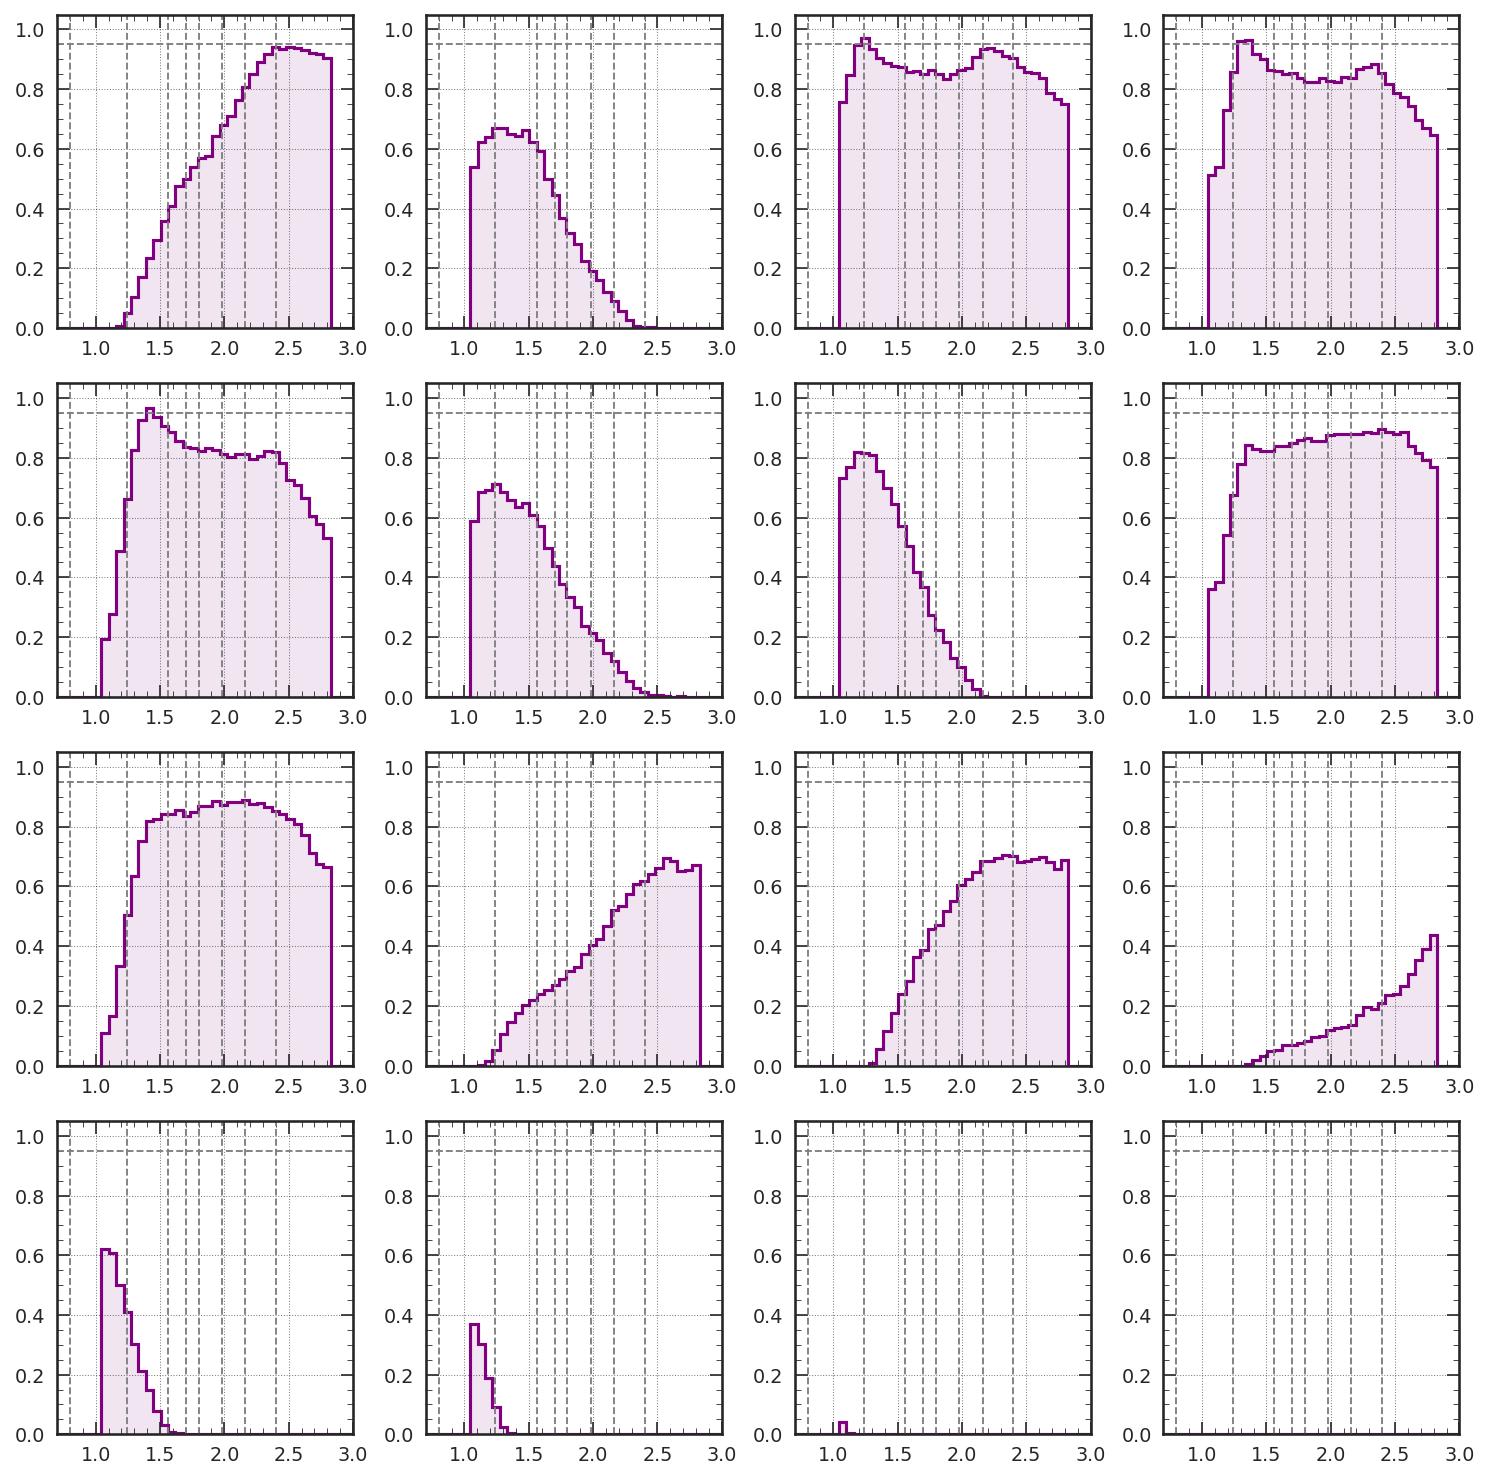

In [15]:
# Efficiency vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'purple'

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(eta, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(eta[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
  hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
  hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  
  # Decorate
  decorate_hist()

plt.show()

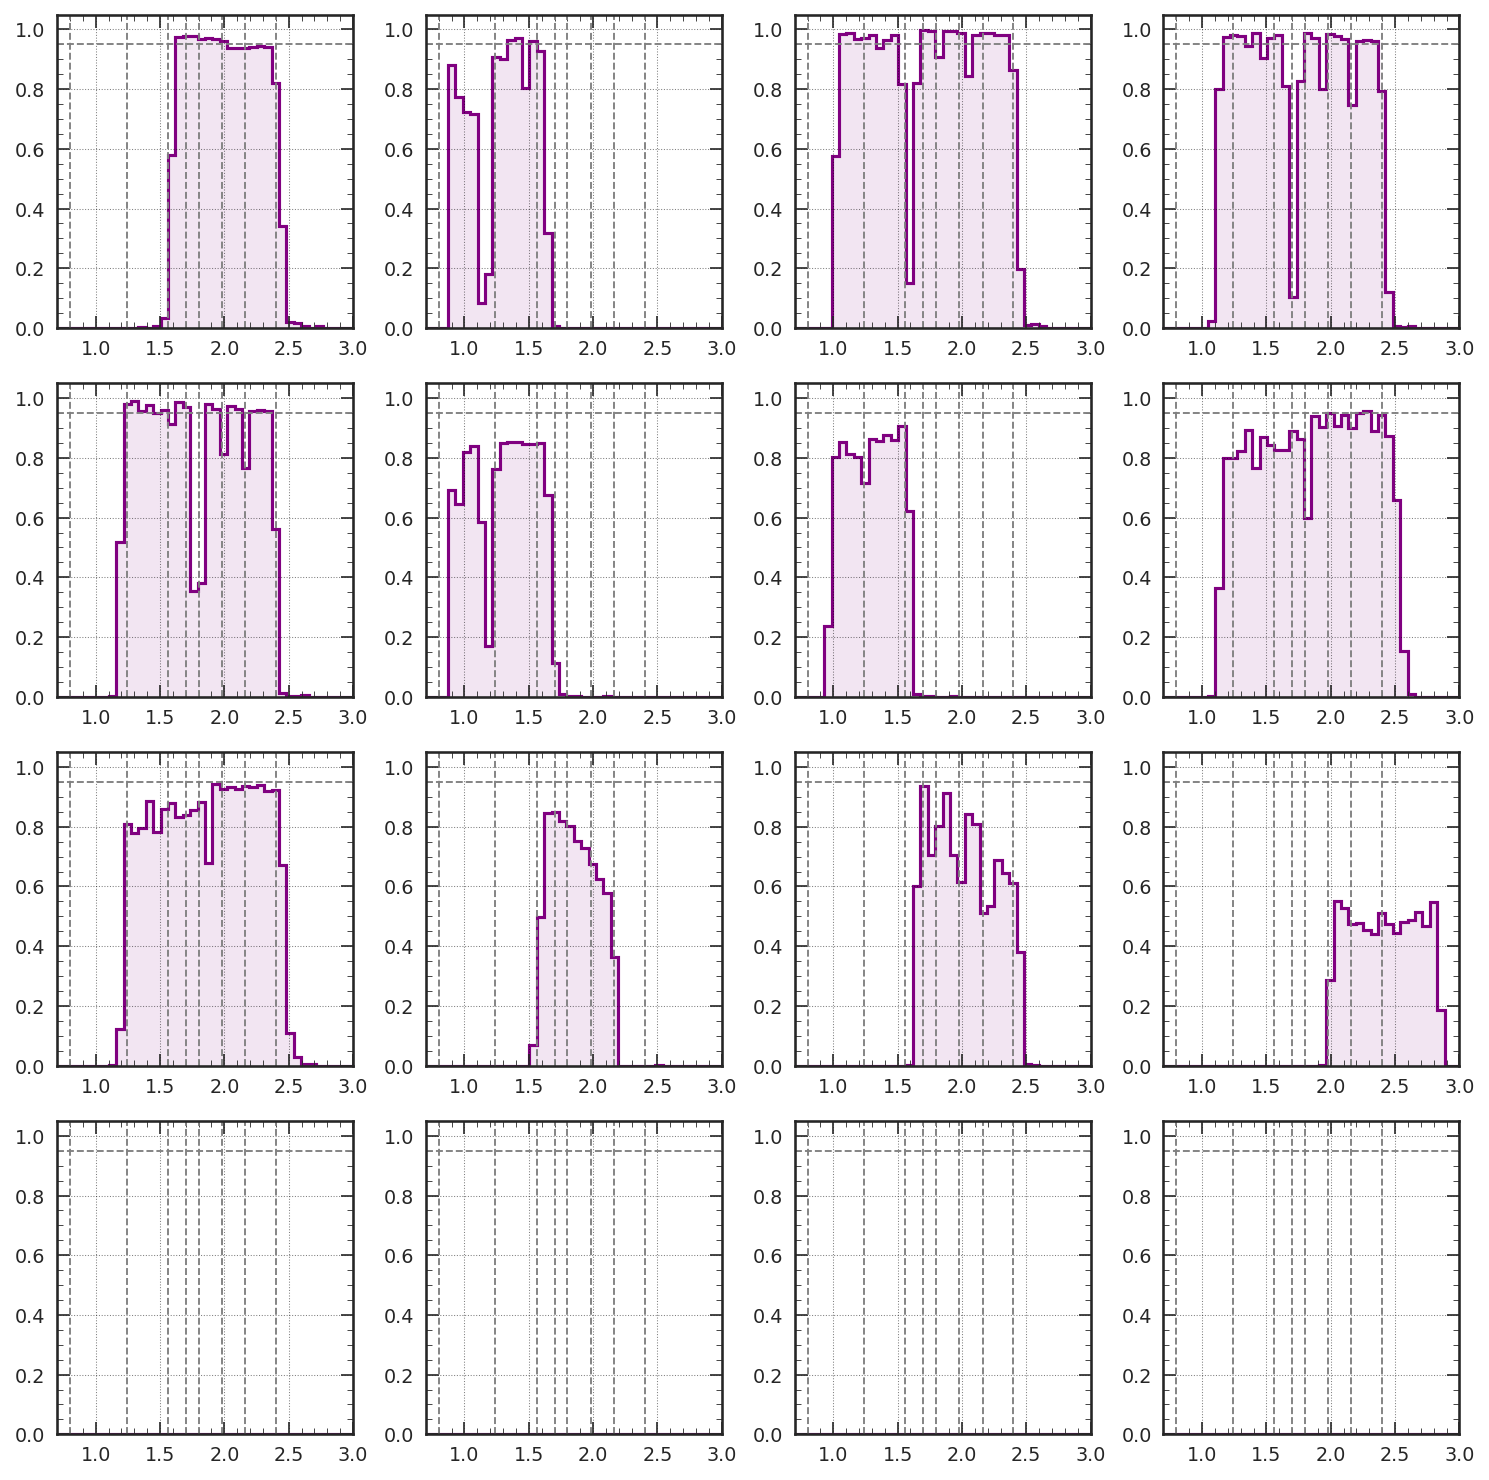

In [16]:
# Efficiency vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'purple'

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(eta, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(eta[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
  hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
  hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  
  # Decorate
  decorate_hist()

plt.show()

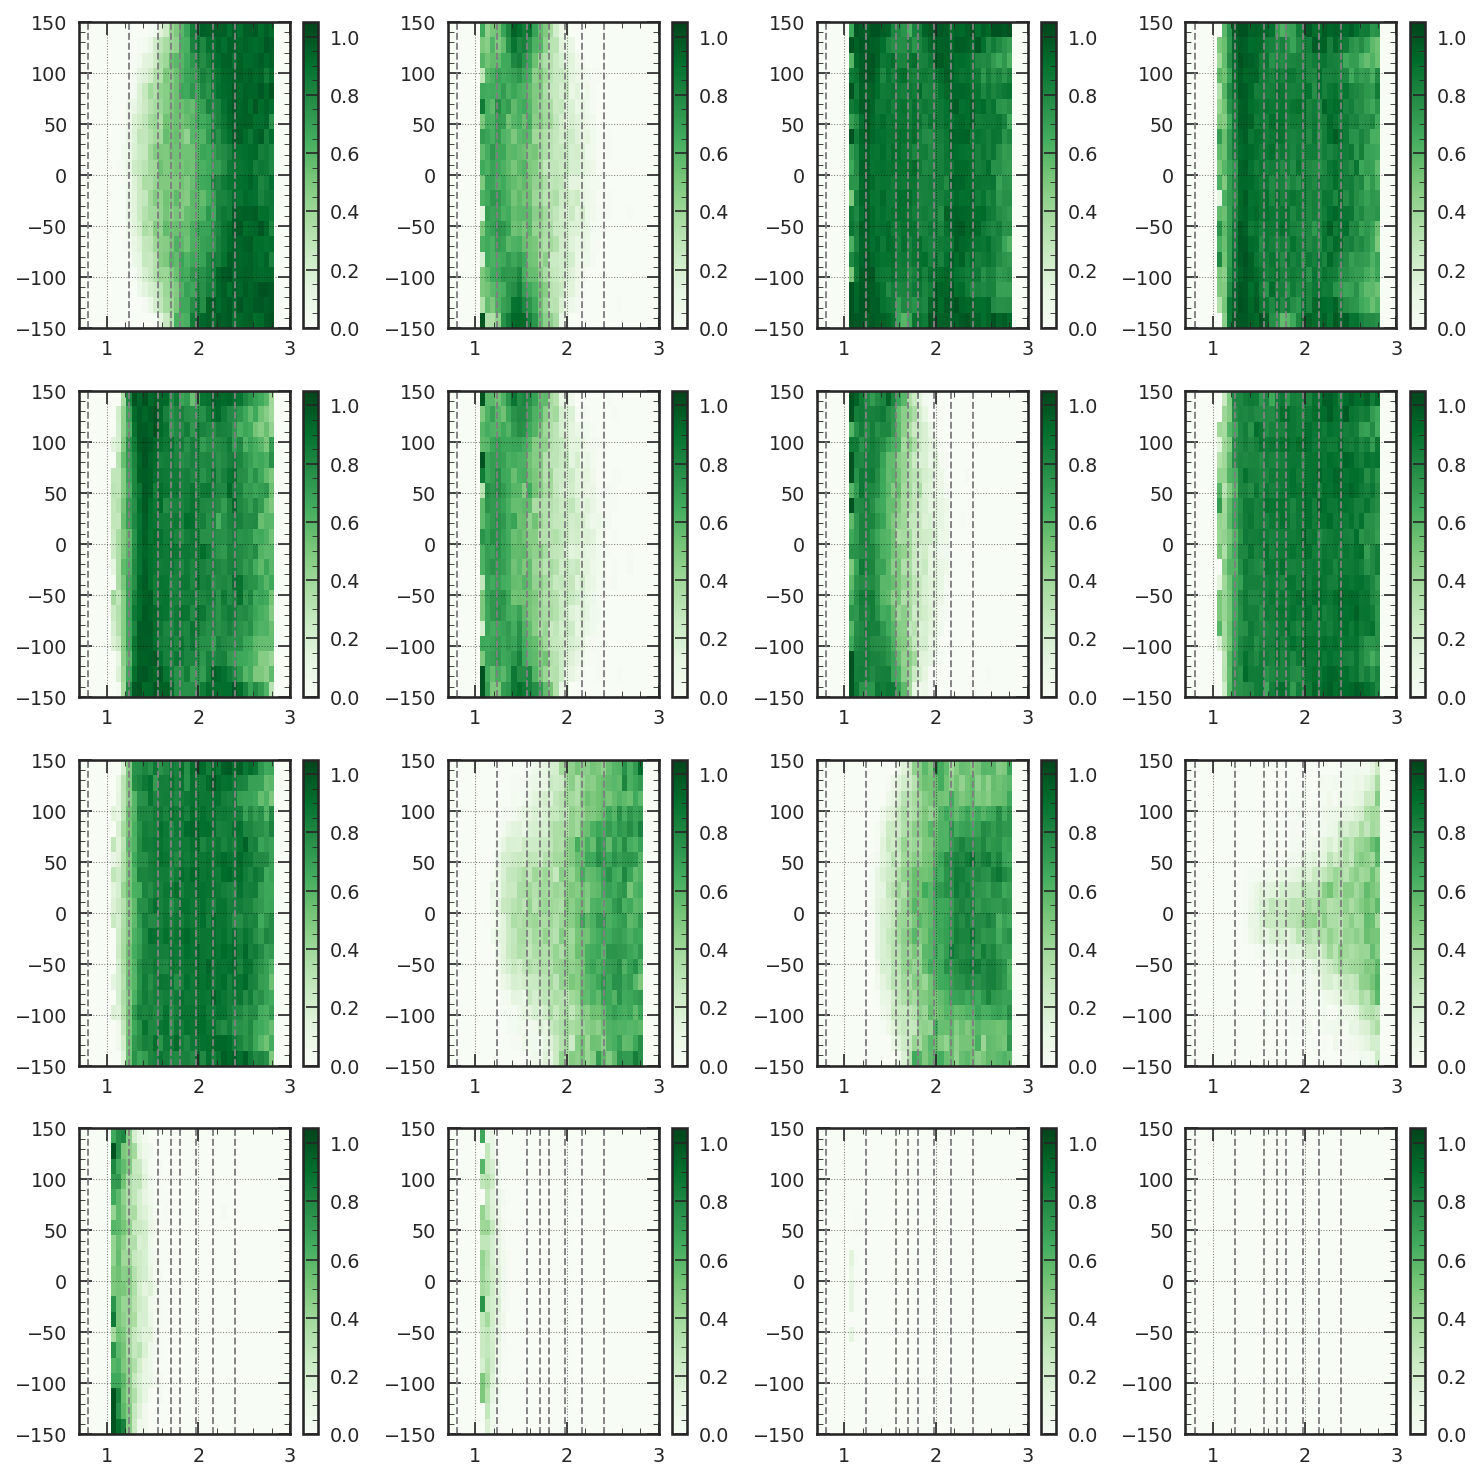

In [17]:
# 2D efficiency d0 vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  d0 = x_d0_array[...,i]  # d0
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()

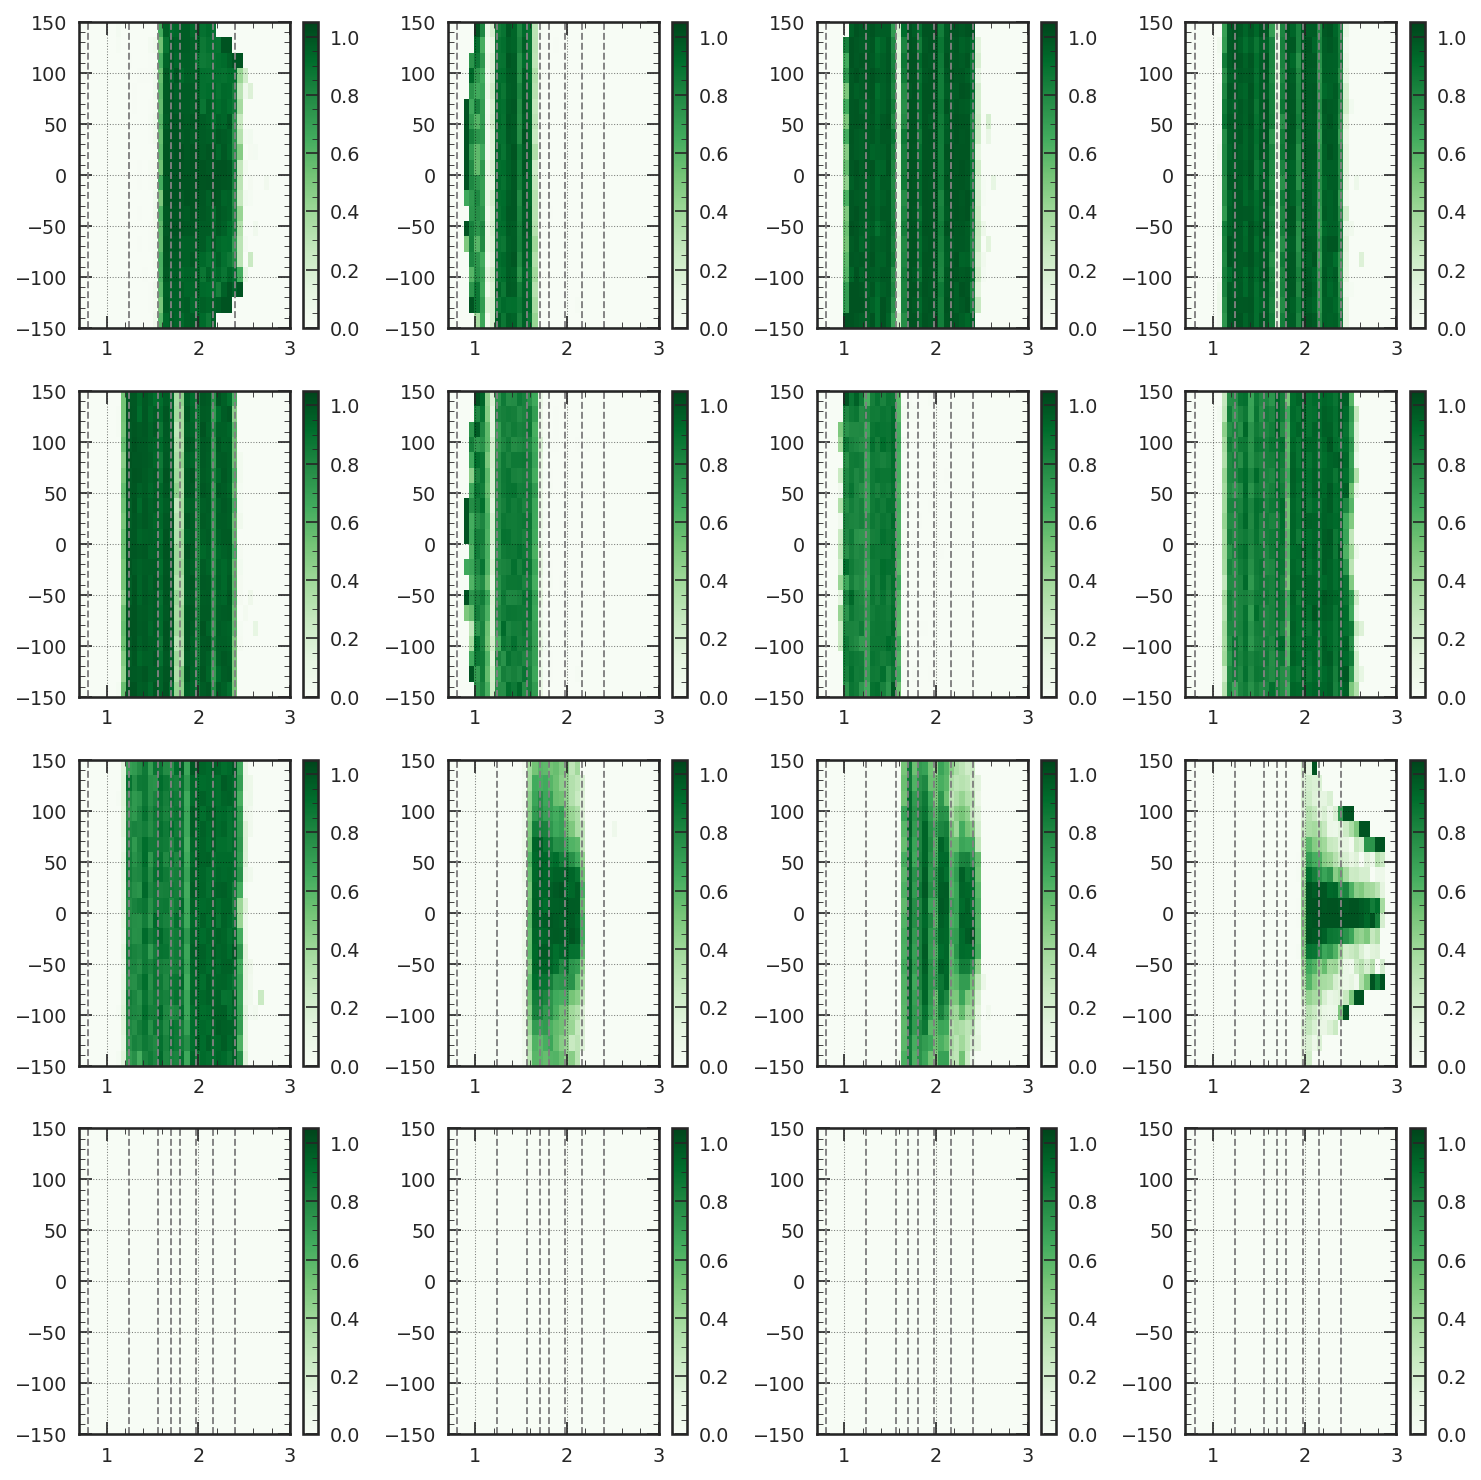

In [18]:
# 2D efficiency d0 vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  d0 = x_d0_array[...,i]  # d0
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()

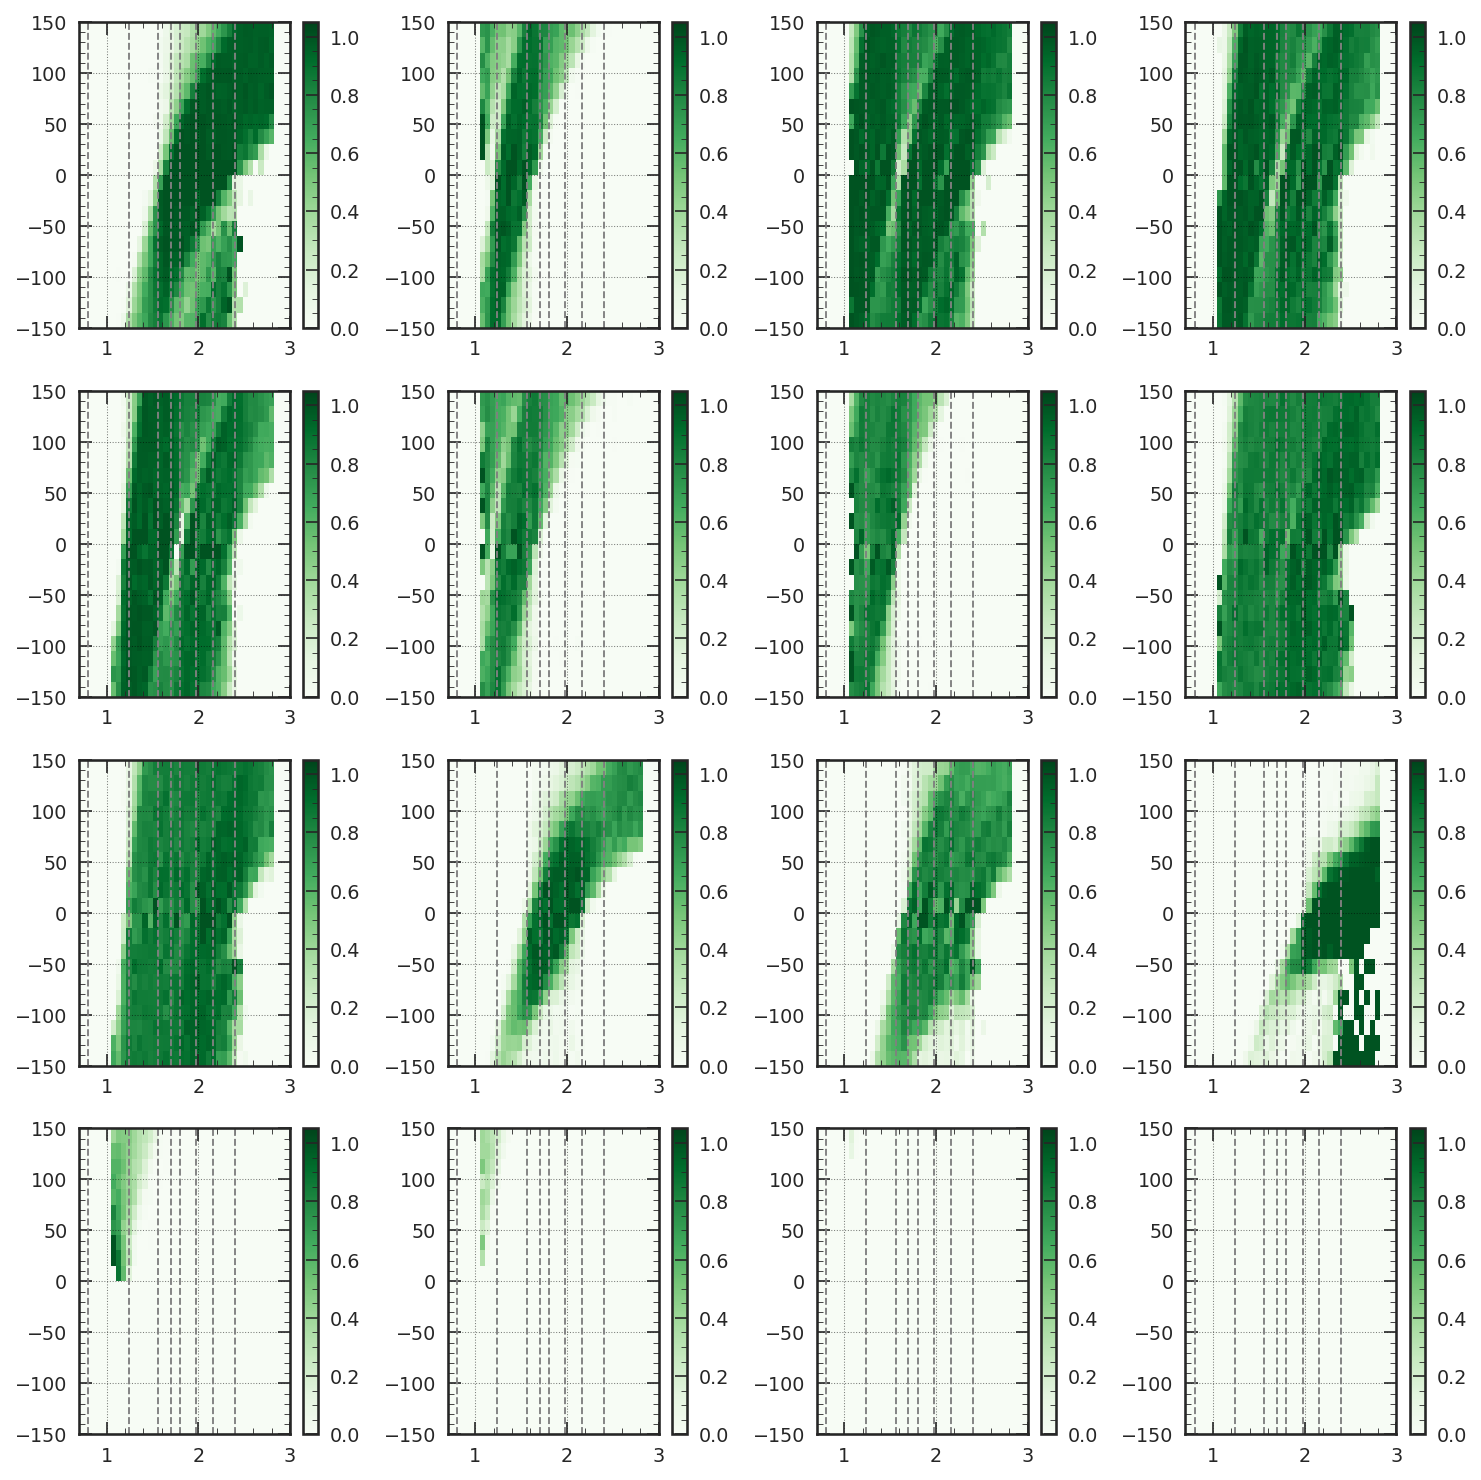

In [19]:
# 2D efficiency r_vtx vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  d0 = x_rvtx_array[...,i]  # r_vtx
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()

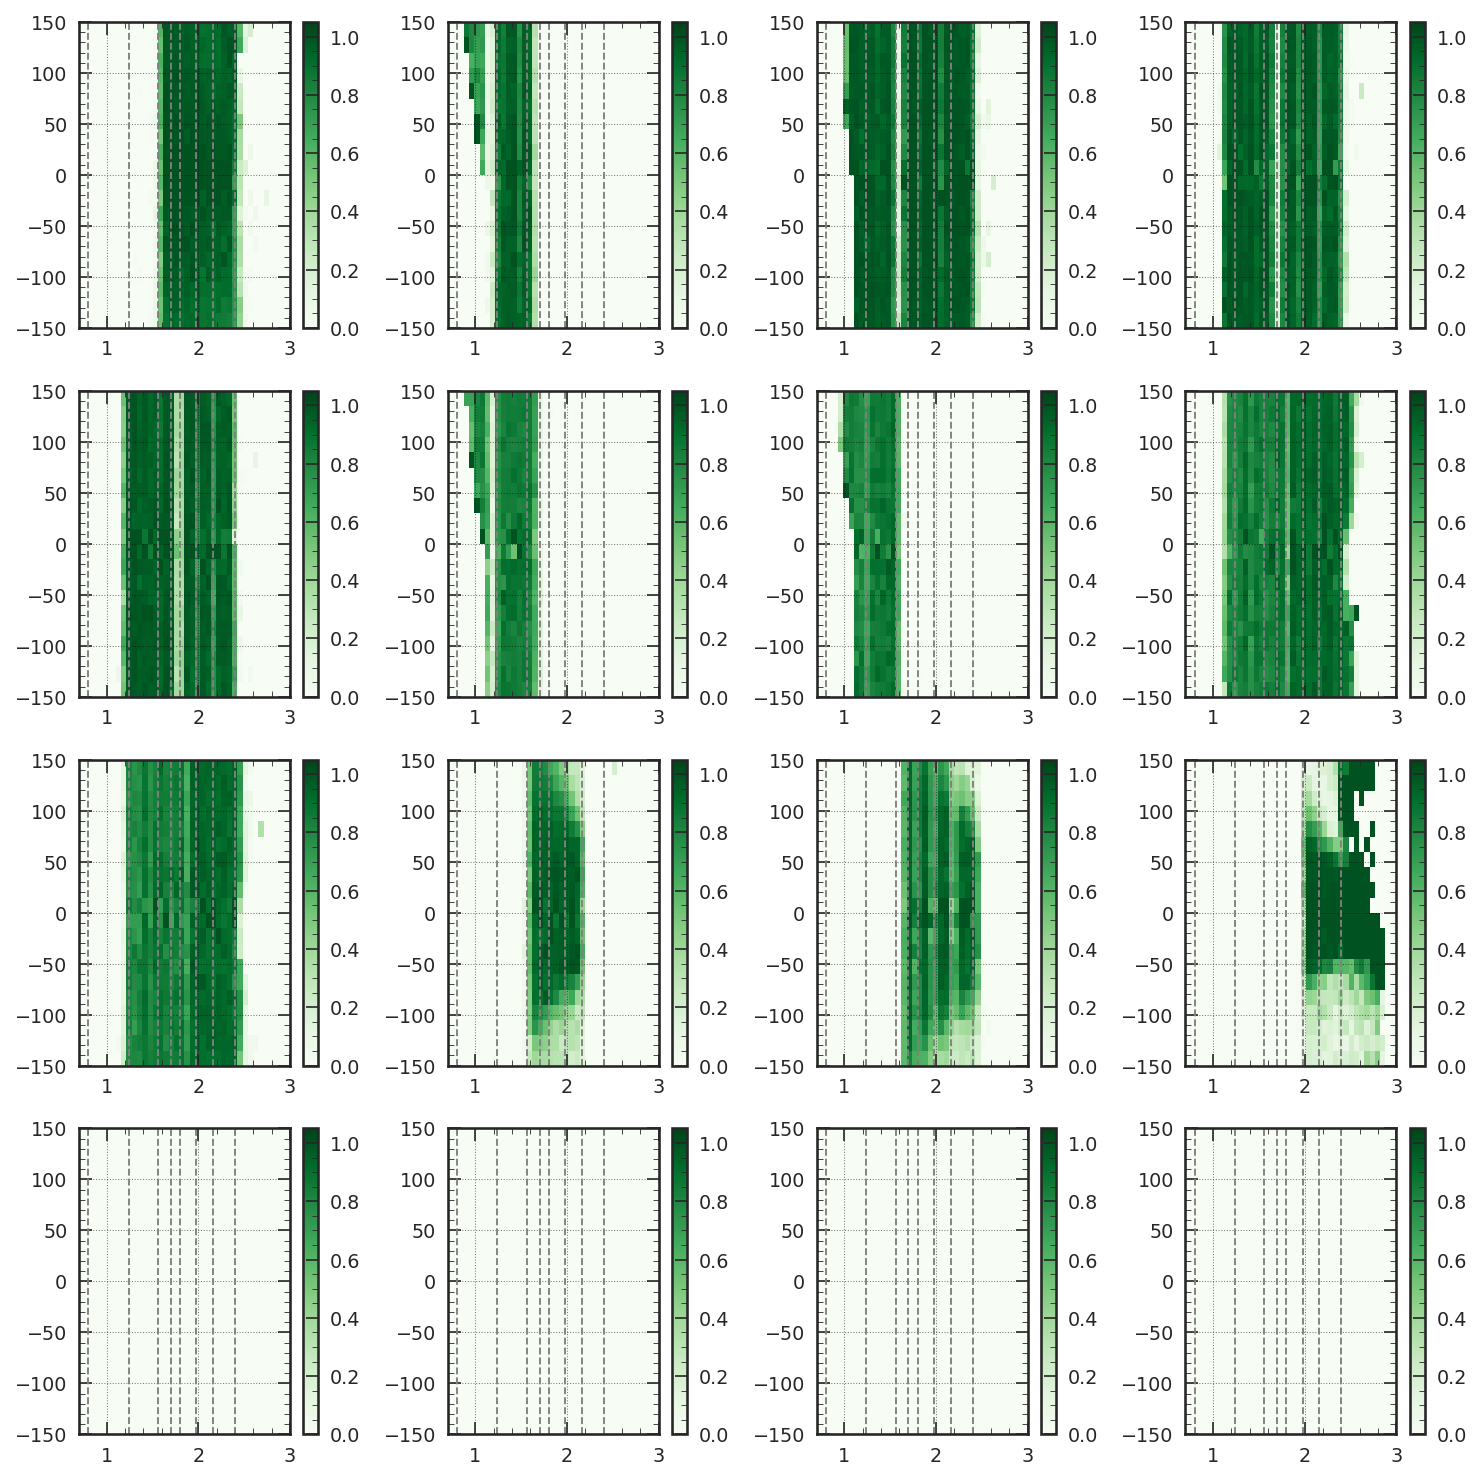

In [20]:
# 2D efficiency r_vtx vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  d0 = x_rvtx_array[...,i]  # r_vtx
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()

## Results (pT > 0 GeV)

In [21]:
# Prepare arrays

x_mask_array = out_hits_xmask.astype(np.bool, copy=True)
x_eta_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_eta[:,np.newaxis]
x_d0_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_d0[:,np.newaxis]
x_etastar_array = out_hits_etastar.copy()
x_rvtx_array = out_hits_rvtx.copy()

x_invpt_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_invpt[:,np.newaxis]

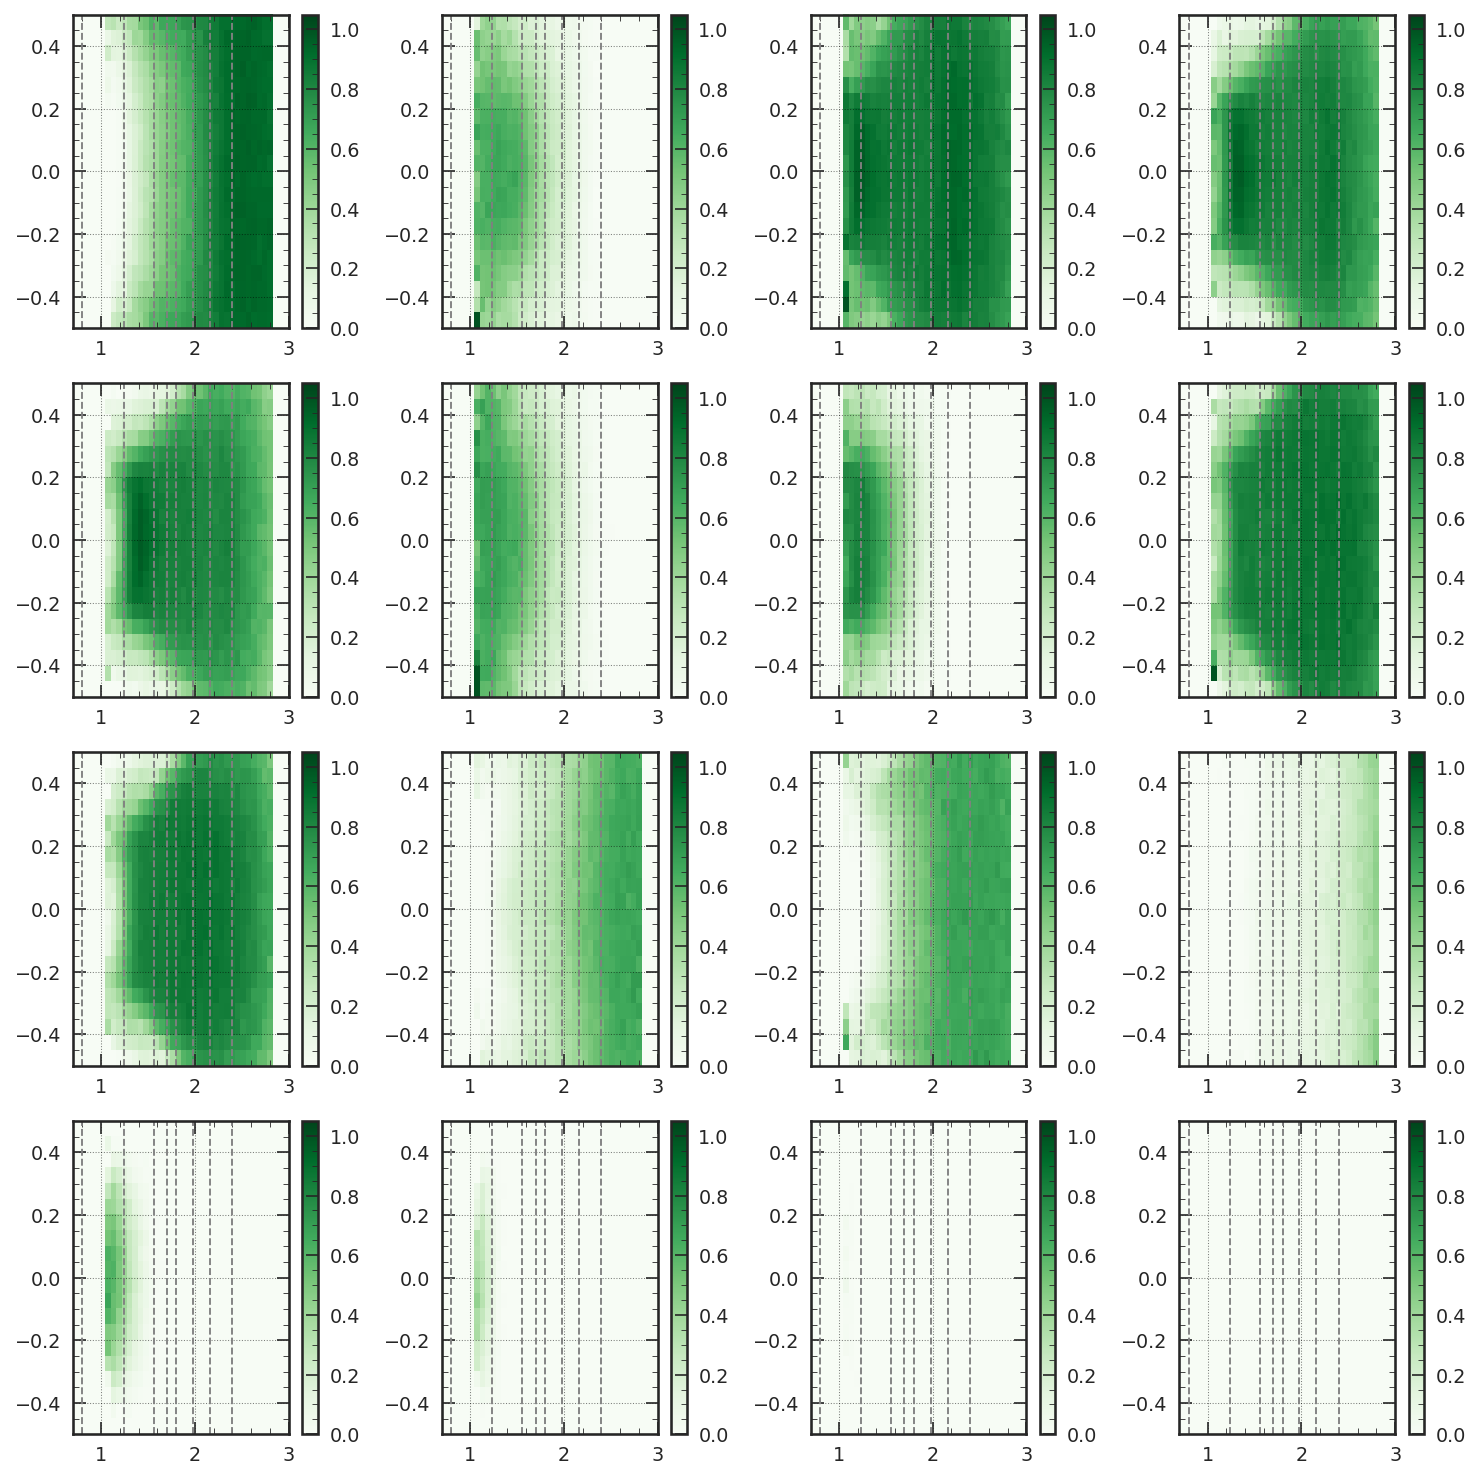

In [22]:
# 2D efficiency q/pT vs eta

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -0.5, 0.5
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  invpt = x_invpt_array[...,i]  # q/pT
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, invpt, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], invpt[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()

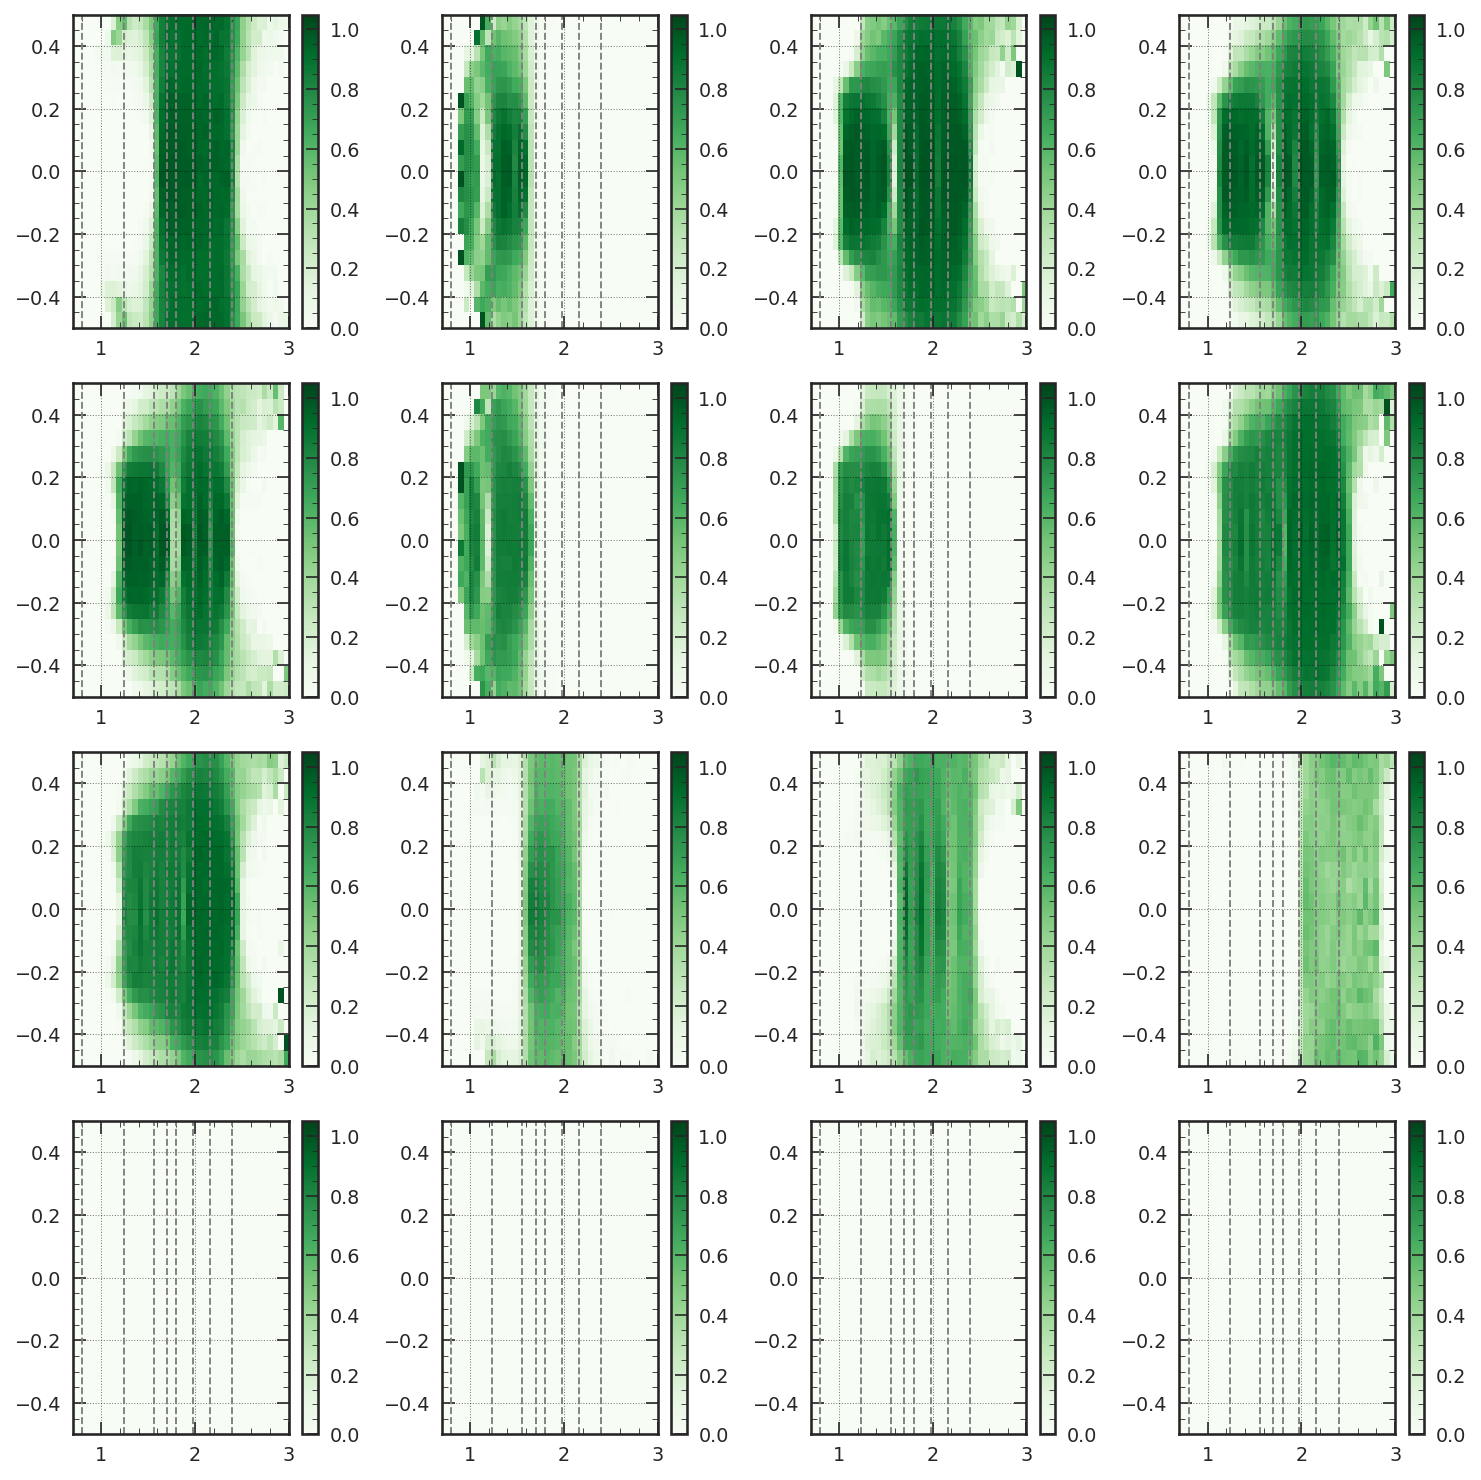

In [23]:
# 2D efficiency q/pT vs etastar

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -0.5, 0.5
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  invpt = x_invpt_array[...,i]  # q/pT
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, invpt, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], invpt[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  
  # Decorate
  decorate_hist2d()

plt.show()